In [1]:
import pandas as pd
import numpy as np
import regex as re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

from imblearn.over_sampling  import RandomOverSampler
from imblearn.under_sampling  import RandomUnderSampler

from IPython.display import display
from itertools import chain
import pickle

## Data extraction

In [2]:
def extract_data(file_name):
    '''
    This method recieves the file name and path as a parameters and extractes the data in the file into a Dataframe
    Returns: Dataframe
    '''
    data = pd.read_json(file_name)
    display(data.head())
    return data

In [3]:
file_name = 'Junior NLP Take Home Test technical_test_data.json'
cust_msg_df = extract_data(file_name)

id                                        Description  \
0   0  - __EMAIL__ Hi , I have just ordered a pair of...   
1   1  I am missing a pair of shoes from my order. Co...   
2   2                 I didn'tget a my order - __EMAIL__   
3   3  Hello, I ordered two __PRODUCTS_NAMES and one ...   
4   4  My shipment never was delivered. The tracking ...   

                                                tags created_at cc_emails  \
0            [category-1, missing-items, field-1456] 2020-03-15        []   
1                       [missing-items, open-ticket] 2021-01-18        []   
2                        [category-1, missing-items] 2019-08-01        []   
3  [category-1, missing-items, open-ticket, field... 2020-08-27        []   
4           [category-1, missing-items, open-ticket] 2019-07-21        []   

  fwd_emails reply_cc_emails ticket_cc_emails fr_escalated   spam  ...  \
0         []              []               []        False  False  ...   
1         []              []               []        False  False  ...   
2         []              []               []        False  False  ...   
3         []              []               []        False  False  ...   
4         []              []               []        False  False  ...   

   priority  requester_id  responder_id  source  company_id  status  \
0         1            30           304       1        None       5   
1         1            30           304       1        None       5   
2         1            30           304       1        None       5   
3         1            30           304       1        None       5   
4         1            30           304       1        None       5   

            subject  association_type      support_email  \
0  Customer Request              None  digitalgenius.com   
1  Customer Request              None  digitalgenius.com   
2  Customer Request              None  digitalgenius.com   
3  Customer Request              None  digitalgenius.com   
4  Customer Request              None  digitalgenius.com   

                       to_emails  
0  ['support@digitalgenius.com']  
1  ['support@digitalgenius.com']  
2  ['support@digitalgenius.com']  
3  ['support@digitalgenius.com']  
4  ['support@digitalgenius.com']  

[5 rows x 22 columns]

## Data Cleaning

In [4]:
cust_msg_df.shape

(1433, 22)

In [5]:
cust_msg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                1433 non-null   int64         
 1   Description       1433 non-null   object        
 2   tags              1433 non-null   object        
 3   created_at        1433 non-null   datetime64[ns]
 4   cc_emails         1433 non-null   object        
 5   fwd_emails        1433 non-null   object        
 6   reply_cc_emails   1433 non-null   object        
 7   ticket_cc_emails  1433 non-null   object        
 8   fr_escalated      1433 non-null   object        
 9   spam              1433 non-null   object        
 10  email_config_id   1433 non-null   int64         
 11  group_id          1433 non-null   int64         
 12  priority          1433 non-null   int64         
 13  requester_id      1433 non-null   int64         
 14  responder_id      1433 n

In [6]:
cust_msg_df.describe(include='all').T

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_69158/4233274979.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  cust_msg_df.describe(include='all').T


count unique  \
id                1433.0    NaN   
Description         1433   1430   
tags                1433    290   
created_at          1433    643   
cc_emails           1433      1   
fwd_emails          1433      1   
reply_cc_emails     1433      1   
ticket_cc_emails    1433      1   
fr_escalated        1433      1   
spam                1433      1   
email_config_id   1433.0    NaN   
group_id          1433.0    NaN   
priority          1433.0    NaN   
requester_id      1433.0    NaN   
responder_id      1433.0    NaN   
source            1433.0    NaN   
company_id          1433      1   
status            1433.0    NaN   
subject             1433      1   
association_type    1433      1   
support_email       1433      1   
to_emails           1433      1   

                                                                top  freq  \
id                                                              NaN   NaN   
Description       I sent in pictures of my on shoes three days a...     2   
tags                               [category-1, other, open-ticket]    27   
created_at                                      2020-03-04 00:00:00    10   
cc_emails                                                        []  1433   
fwd_emails                                                       []  1433   
reply_cc_emails                                                  []  1433   
ticket_cc_emails                                                 []  1433   
fr_escalated                                                  False  1433   
spam                                                          False  1433   
email_config_id                                                 NaN   NaN   
group_id                                                        NaN   NaN   
priority                                                        NaN   NaN   
requester_id                                                    NaN   NaN   
responder_id                                                    NaN   NaN   
source                                                          NaN   NaN   
company_id                                                     None  1433   
status                                                          NaN   NaN   
subject                                            Customer Request  1433   
association_type                                               None  1433   
support_email                                     digitalgenius.com  1433   
to_emails                             ['support@digitalgenius.com']  1433   

                      first       last      mean        std       min  \
id                      NaT        NaT     716.0  413.81578       0.0   
Description             NaT        NaT       NaN        NaN       NaN   
tags                    NaT        NaT       NaN        NaN       NaN   
created_at       2019-01-01 2021-01-31       NaN        NaN       NaN   
cc_emails               NaT        NaT       NaN        NaN       NaN   
fwd_emails              NaT        NaT       NaN        NaN       NaN   
reply_cc_emails         NaT        NaT       NaN        NaN       NaN   
ticket_cc_emails        NaT        NaT       NaN        NaN       NaN   
fr_escalated            NaT        NaT       NaN        NaN       NaN   
spam                    NaT        NaT       NaN        NaN       NaN   
email_config_id         NaT        NaT  750498.0        0.0  750498.0   
group_id                NaT        NaT    3043.0        0.0    3043.0   
priority                NaT        NaT       1.0        0.0       1.0   
requester_id            NaT        NaT      30.0        0.0      30.0   
responder_id            NaT        NaT     304.0        0.0     304.0   
source                  NaT        NaT       1.0        0.0       1.0   
company_id              NaT        NaT       NaN        NaN       NaN   
status                  NaT        NaT       5.0        0.0       5.0   
subject                 NaT        NaT       NaN      

In [7]:
cust_msg_df.columns

Index(['id', 'Description', 'tags', 'created_at', 'cc_emails', 'fwd_emails',
       'reply_cc_emails', 'ticket_cc_emails', 'fr_escalated', 'spam',
       'email_config_id', 'group_id', 'priority', 'requester_id',
       'responder_id', 'source', 'company_id', 'status', 'subject',
       'association_type', 'support_email', 'to_emails'],
      dtype='object')

In [8]:
# Checking for null values 

cust_msg_df.isnull().sum()

id                  0
Description         0
tags                0
created_at          0
cc_emails           0
fwd_emails          0
reply_cc_emails     0
ticket_cc_emails    0
fr_escalated        0
spam                0
email_config_id     0
group_id            0
priority            0
requester_id        0
responder_id        0
source              0
company_id          0
status              0
subject             0
association_type    0
support_email       0
to_emails           0
dtype: int64

In [9]:
# Checking for duplicates

cust_msg_df[cust_msg_df.id.duplicated()]

Empty DataFrame
Columns: [id, Description, tags, created_at, cc_emails, fwd_emails, reply_cc_emails, ticket_cc_emails, fr_escalated, spam, email_config_id, group_id, priority, requester_id, responder_id, source, company_id, status, subject, association_type, support_email, to_emails]
Index: []

[0 rows x 22 columns]

In [10]:
# Checking columns with no varaince

col_no_var =[col for col in cust_msg_df.columns if len(cust_msg_df[col].value_counts()) == 1]
col_no_var

['cc_emails',
 'fwd_emails',
 'reply_cc_emails',
 'ticket_cc_emails',
 'fr_escalated',
 'spam',
 'email_config_id',
 'group_id',
 'priority',
 'requester_id',
 'responder_id',
 'source',
 'company_id',
 'status',
 'subject',
 'association_type',
 'support_email',
 'to_emails']

In [11]:
# Removing columns with no variance

cust_msg_df = cust_msg_df.drop(col_no_var,axis=1)
cust_msg_df.head()

id                                        Description  \
0   0  - __EMAIL__ Hi , I have just ordered a pair of...   
1   1  I am missing a pair of shoes from my order. Co...   
2   2                 I didn'tget a my order - __EMAIL__   
3   3  Hello, I ordered two __PRODUCTS_NAMES and one ...   
4   4  My shipment never was delivered. The tracking ...   

                                                tags created_at  
0            [category-1, missing-items, field-1456] 2020-03-15  
1                       [missing-items, open-ticket] 2021-01-18  
2                        [category-1, missing-items] 2019-08-01  
3  [category-1, missing-items, open-ticket, field... 2020-08-27  
4           [category-1, missing-items, open-ticket] 2019-07-21

In [12]:
# Removind id column

cust_msg_df =cust_msg_df.drop('id',axis=1)
cust_msg_df.head()

Description  \
0  - __EMAIL__ Hi , I have just ordered a pair of...   
1  I am missing a pair of shoes from my order. Co...   
2                 I didn'tget a my order - __EMAIL__   
3  Hello, I ordered two __PRODUCTS_NAMES and one ...   
4  My shipment never was delivered. The tracking ...   

                                                tags created_at  
0            [category-1, missing-items, field-1456] 2020-03-15  
1                       [missing-items, open-ticket] 2021-01-18  
2                        [category-1, missing-items] 2019-08-01  
3  [category-1, missing-items, open-ticket, field... 2020-08-27  
4           [category-1, missing-items, open-ticket] 2019-07-21

In [13]:
# Checking created_at values 
cust_msg_df.created_at.value_counts().sum()

1433

In [14]:
stop_words = set(stopwords.words('english'))
def clean_description(description):
    '''
    This method cleans description by converting to lower, removing punctuations, numbers, new line and extra spaces
    Also removes stop words and stem and lemmatize text
    Return : processed description
    '''
    description = description.lower()
    description = re.sub(r"[^\\\w\s]",' ',description)
    description = re.sub(r'_*\w*_+',' ',description)
    description = re.sub(r'(\s)__\w*',' ',description)
    description = re.sub(r'\n',' ',description)
    description = re.sub(r"[0-9]",'',description)
    description = re.sub(r" +",' ',description)
    description=description.strip()
    
    word_tokens = word_tokenize(description)
    filtered_text = [w for w in word_tokens if not w in stop_words] 
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in filtered_text]
    
    lemma = WordNetLemmatizer()
    tokens =[lemma.lemmatize(t) for t in tokens]
    
    return (' '.join(filtered_text))


cust_msg_df['Description'] = cust_msg_df.Description.apply(clean_description)
cust_msg_df.head()

Description  \
0  hi ordered pair put relevant code free bag new...   
1  missing pair shoes order could someone please ...   
2                                         tget order   
3  hello ordered two names one received two could...   
4  shipment never delivered tracking says deliver...   

                                                tags created_at  
0            [category-1, missing-items, field-1456] 2020-03-15  
1                       [missing-items, open-ticket] 2021-01-18  
2                        [category-1, missing-items] 2019-08-01  
3  [category-1, missing-items, open-ticket, field... 2020-08-27  
4           [category-1, missing-items, open-ticket] 2019-07-21

In [15]:
def clean_tags(tags):
    '''
    This method cleans tags and converts into text
    Return : Cleaned tags
    '''
    clean_tags =[]
    for tag in tags:
        clean_tag = clean_description(tag)
        clean_tags.append(clean_tag)
    return ' '.join(clean_tags)

cust_msg_df['clean_tags'] = cust_msg_df.tags.apply(clean_tags)
cust_msg_df.head()

Description  \
0  hi ordered pair put relevant code free bag new...   
1  missing pair shoes order could someone please ...   
2                                         tget order   
3  hello ordered two names one received two could...   
4  shipment never delivered tracking says deliver...   

                                                tags created_at  \
0            [category-1, missing-items, field-1456] 2020-03-15   
1                       [missing-items, open-ticket] 2021-01-18   
2                        [category-1, missing-items] 2019-08-01   
3  [category-1, missing-items, open-ticket, field... 2020-08-27   
4           [category-1, missing-items, open-ticket] 2019-07-21   

                                 clean_tags  
0              category missing items field  
1                 missing items open ticket  
2                    category missing items  
3  category missing items open ticket field  
4        category missing items open ticket

## Data Analysis

In [16]:
cust_msg_df.created_at.describe()

/var/folders/0r/q_8nrq1s77lbvmzhtbgcwsbw0000gn/T/ipykernel_69158/391076637.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  cust_msg_df.created_at.describe()


count                    1433
unique                    643
top       2020-03-04 00:00:00
freq                       10
first     2019-01-01 00:00:00
last      2021-01-31 00:00:00
Name: created_at, dtype: object

In [17]:
# Creating columns for month and year of creation

cust_msg_df['Month_created'] = cust_msg_df.created_at.dt.month_name()
cust_msg_df['Year_created'] = cust_msg_df.created_at.dt.year

# cust_msg_df.head()

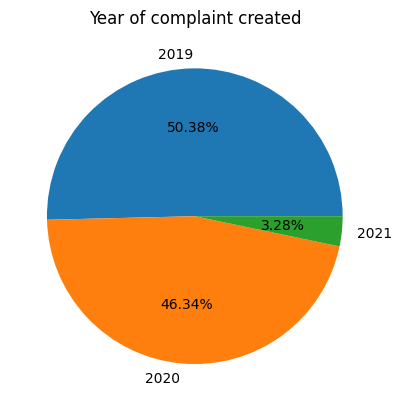

In [18]:
# Visualizing the years of creation
year = cust_msg_df.Year_created.value_counts().sort_index()
year

plt.pie(year,labels=list(year.index),autopct="%.2f%%")
plt.title('Year of complaint created')
plt.show()

Maximum customer support emails in the year 2019. Minimum in 2021 but there is only information till March in the year 2021

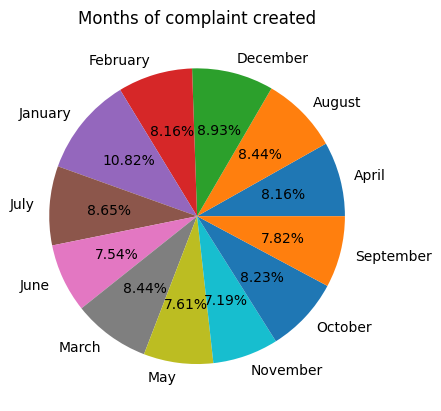

In [19]:
# Visualizing months of creation
month = cust_msg_df.Month_created.value_counts().sort_index()

plt.pie(month,labels= list(month.index),autopct='%.2f%%')
plt.title('Months of complaint created')
plt.show()

January has the most number of emails. But the dataset contains information for 3 years of January  and 2 years for rest of the months. So the number of messages are almost simsilar for most months.

In [20]:
# Checking the tags column

all_tags = set()
for tag in cust_msg_df.tags.values:
#     vals = tag.split(',')
    all_tags.update(tag)
all_tags

{'?',
 'add-item',
 'adverse-effect',
 'arrived-damaged',
 'cancel-order',
 'cancel-subscription',
 'category-1',
 'change-delivery-address',
 'change-delivery-date',
 'change-items',
 'discounts-questions',
 'donation-requests',
 'exchange',
 'faulty-product',
 'field-1456',
 'how-to-return',
 'language',
 'lost-package',
 'missing-items',
 'not-a-request',
 'open-ticket',
 'order-confirmation-not-received',
 'order-confirmation-not-received,-return-questions-',
 'other',
 'price-adjustment',
 'promocode-not-working',
 'remove-item',
 'return-label',
 'return-status',
 'shipping-price',
 'ticket',
 'update-account-information',
 'warranty-claim-status',
 'warranty-policy-information',
 'where-is-my-order',
 'wrong-item-delivered'}

In [21]:
tags_counts = cust_msg_df.tags.value_counts()
tags_counts
    

[category-1, other, open-ticket]                                                        27
[category-1, discounts-questions, field-1456]                                           25
[category-1, discounts-questions, open-ticket]                                          24
[category-1, promocode-not-working, open-ticket, field-1456]                            24
[category-1, exchange, field-1456]                                                      24
                                                                                        ..
[ticket, return-status, field-1456]                                                      1
[category-1, ticket, other, open-ticket]                                                 1
[ticket, other]                                                                          1
[category-1, ticket, order-confirmation-not-received,-return-questions-, field-1456]     1
[category-1, adverse-effect, open-ticket, field-1456]                                    1

In [22]:
# Getting the count of each tags in cust_msg
tag_list =[]
for i in range(len(tags_counts)):
    tag_list.append(tags_counts.index[i]*tags_counts[i])

    
Counter(list(chain.from_iterable(tag_list)))

Counter({'category-1': 900,
         'other': 127,
         'open-ticket': 700,
         'discounts-questions': 150,
         'field-1456': 800,
         'promocode-not-working': 159,
         'exchange': 150,
         'how-to-return': 150,
         'where-is-my-order': 150,
         'order-confirmation-not-received': 86,
         'ticket': 300,
         'faulty-product': 73,
         'price-adjustment': 51,
         'warranty-claim-status': 49,
         'return-label': 57,
         'not-a-request': 27,
         'return-status': 23,
         'warranty-policy-information': 27,
         'change-delivery-address': 19,
         'wrong-item-delivered': 23,
         '?': 13,
         'donation-requests': 12,
         'change-delivery-date': 16,
         'missing-items': 19,
         'cancel-subscription': 12,
         'lost-package': 9,
         'shipping-price': 11,
         'language': 1,
         'remove-item': 2,
         'add-item': 3,
         'change-items': 5,
         'arrived-damag

Relevant tags for question "Where is my order" are 'where-is-my-order','order-confirmation-not-received' and 'order-confirmation-not-received,-return-questions-'

Most occuring tags are - 'category-1','open-ticket'and 'field-1456'

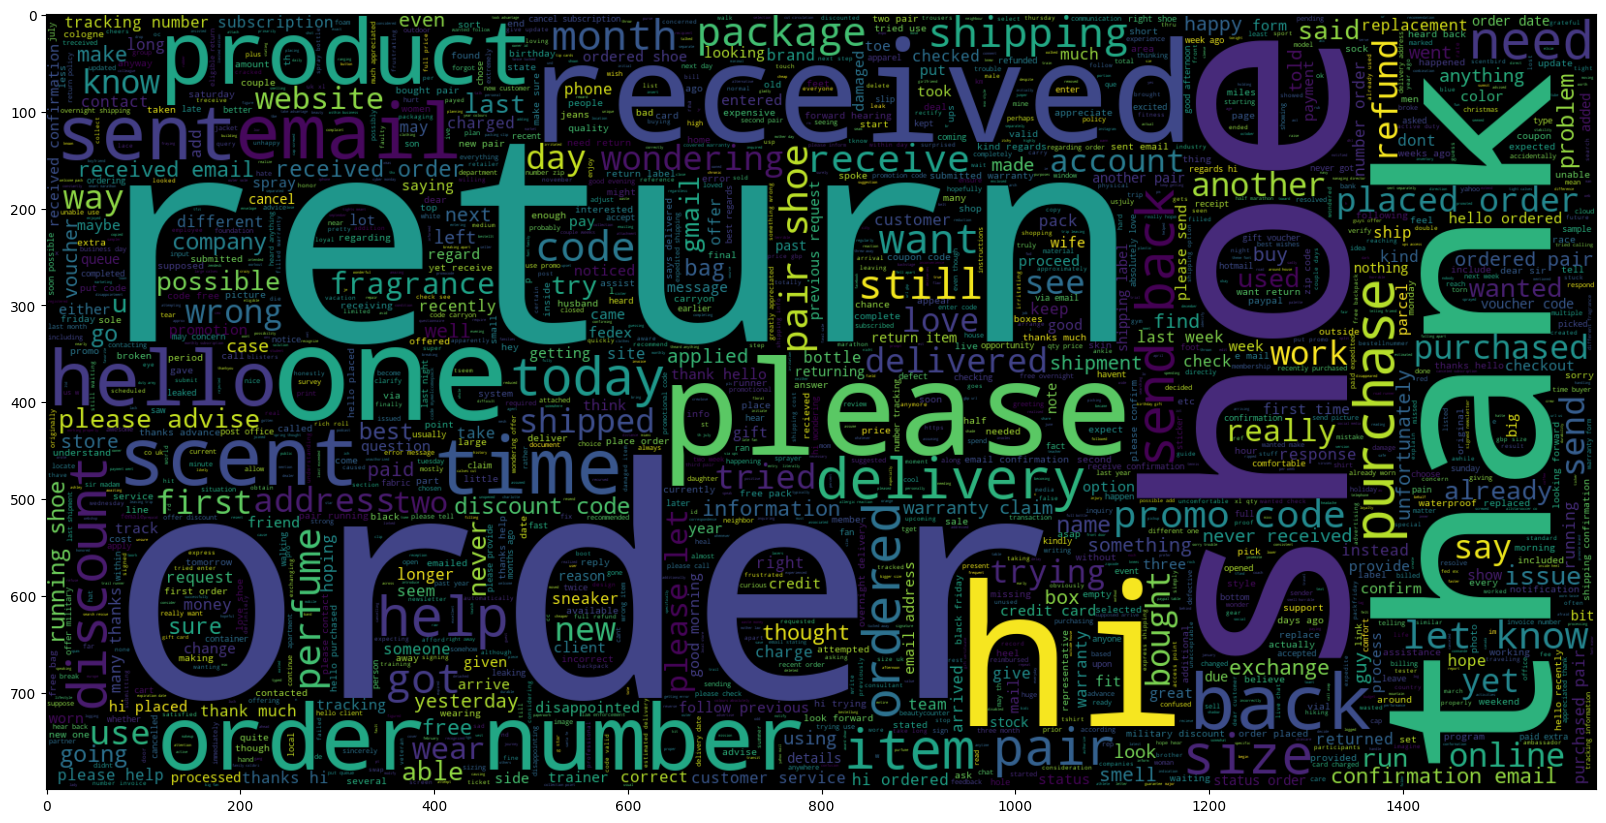

In [23]:
# Most common words in description

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(cust_msg_df.Description))
                                                                                 
plt.imshow(wc , interpolation = 'bilinear')

In [24]:
# Length of messages

cust_msg_df['length'] = cust_msg_df.Description.apply(lambda x: len(x))
cust_msg_df.head()

Description  \
0  hi ordered pair put relevant code free bag new...   
1  missing pair shoes order could someone please ...   
2                                         tget order   
3  hello ordered two names one received two could...   
4  shipment never delivered tracking says deliver...   

                                                tags created_at  \
0            [category-1, missing-items, field-1456] 2020-03-15   
1                       [missing-items, open-ticket] 2021-01-18   
2                        [category-1, missing-items] 2019-08-01   
3  [category-1, missing-items, open-ticket, field... 2020-08-27   
4           [category-1, missing-items, open-ticket] 2019-07-21   

                                 clean_tags Month_created  Year_created  \
0              category missing items field         March          2020   
1                 missing items open ticket       January          2021   
2                    category missing items        August          2019   
3  category missing items open ticket field        August          2020   
4        category missing items open ticket          July          2019   

   length  
0     141  
1      87  
2      10  
3     104  
4     129

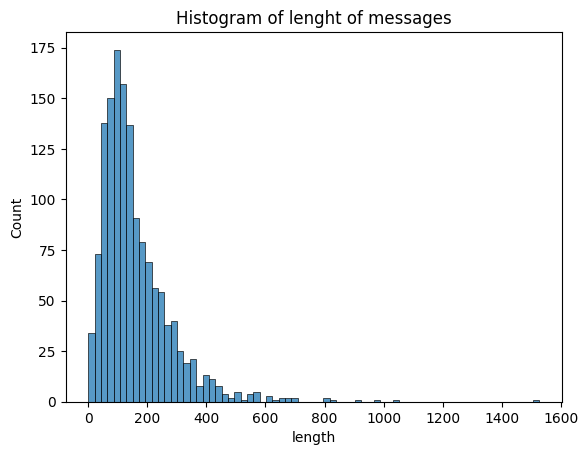

In [25]:
sns.histplot(x='length',data=cust_msg_df)
plt.title('Histogram of lenght of messages')
plt.show()

Most of the messages have length between 50-250 words. Very few have lenght more than 400 words

## Building target label

Building target label based on tags.
Most relevant tags for question - Is the customer asking for the status of his order? are

'where-is-my-order','order-confirmation-not-received' and 'order-confirmation-not-received,-return-questions-'

In [26]:
tags_order_status = ['where-is-my-order','order-confirmation-not-received',
                     'order-confirmation-not-received,-return-questions-']

In [27]:
# Checking few other labels which could have relevant messages
tags_to_check = 'other'

def get_tag(tag):
    return True if '?' in tag else False

In [28]:
print(cust_msg_df[cust_msg_df.tags.apply(get_tag)].Description.values)

['dear sirs recently placed order visible profile account however receive confirmation shipment etc could please let know status order moreover wanted use promotion get pack free code mywelcomepack able add pack order could please add one gray thank advance support best regards'
 'good evening wondering warranty products purchased pair months back barely put miles injury trainers praise enough time heels completely fell away give advice kind regards'
 'order pair shoes last night check order ship yet want change shoes call please number'
 'placed order last week pair sneakers never received confirmation email though start getting marketing emails second got email yesterday offering free first purchase known would get free first purchase sneakers bought one please let know order even went place another one credit address thank'
 'hello friday evening contact person company elastic lacers new lady said would send black lacers fast delivery leaving miami tomorrow tracking number address m

In [29]:
def label(tags):
    for tag in tags:
        
        if tag in tags_order_status:
            return 1
    return 0

In [30]:
cust_msg_df['label'] = cust_msg_df.tags.apply(label)
cust_msg_df.head()

Description  \
0  hi ordered pair put relevant code free bag new...   
1  missing pair shoes order could someone please ...   
2                                         tget order   
3  hello ordered two names one received two could...   
4  shipment never delivered tracking says deliver...   

                                                tags created_at  \
0            [category-1, missing-items, field-1456] 2020-03-15   
1                       [missing-items, open-ticket] 2021-01-18   
2                        [category-1, missing-items] 2019-08-01   
3  [category-1, missing-items, open-ticket, field... 2020-08-27   
4           [category-1, missing-items, open-ticket] 2019-07-21   

                                 clean_tags Month_created  Year_created  \
0              category missing items field         March          2020   
1                 missing items open ticket       January          2021   
2                    category missing items        August          2019   
3  category missing items open ticket field        August          2020   
4        category missing items open ticket          July          2019   

   length  label  
0     141      0  
1      87      0  
2      10      0  
3     104      0  
4     129      0

In [31]:
cust_msg_df[cust_msg_df.label == 1]

Description  \
19   hello delivery date check package tracking inf...   
20   ordered day shipping ordered said would leavin...   
21   ordered pair got answer email see paid shoes t...   
22     order number please provide delivery date thank   
23   reported missing delivery yesterday received e...   
..                                                 ...   
251  ordered pair last tuesday yet receive shipping...   
252  ordered size women black received confirmation...   
253  black friday purchase hi ordered pair waterpro...   
254  order shipped hello recently bought shoes orde...   
593  order number hi ordered confirmation shipping ...   

                                                  tags created_at  \
19         [category-1, where-is-my-order, field-1456] 2020-08-13   
20        [category-1, where-is-my-order, open-ticket] 2020-12-12   
21                     [category-1, where-is-my-order] 2019-11-29   
22                     [where-is-my-order, field-1456] 2019-08-06   
23                     [category-1, where-is-my-order] 2020-03-17   
..                                                 ...        ...   
251  [category-1, order-confirmation-not-received, ... 2020-05-17   
252      [order-confirmation-not-received, field-1456] 2020-03-22   
253  [category-1, ticket, order-confirmation-not-re... 2019-05-16   
254      [order-confirmation-not-received, field-1456] 2019-09-14   
593  [category-1, ticket, order-confirmation-not-re... 2019-10-14   

                                            clean_tags Month_created  \
19                                category order field        August   
20                          category order open ticket      December   
21                                      category order      November   
22                                         order field        August   
23                                      category order         March   
..                                                 ...           ...   
251         category order confirmation received field           May   
252                  order confirmation received field         March   
253        category ticket order confirmation received           May   
254                  order confirmation received field     September   
593  category ticket order confirmation received re...       October   

     Year_created  length  label  
19           2020     226      1  
20           2020     124      1  
21           2019      85      1  
22           2019      47      1  
23           2020     140      1  
..            ...     ...    ...  
251          2020     146      1  
252          2020     121      1  
253          2019     300      1  
254          2019     182      1  
593          2019     128      1  

[237 rows x 8 columns]

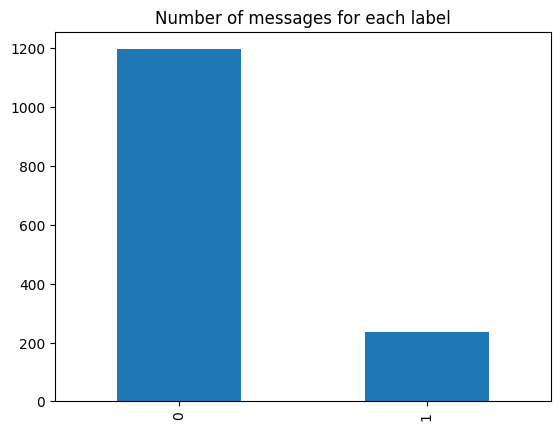

In [32]:
# Distribution of labels

cust_msg_df.label.value_counts().plot(kind='bar')
plt.title('Number of messages for each label')
plt.show()

The dataset is highly imbalanced. Sampling might be required to create a sensible model for classification

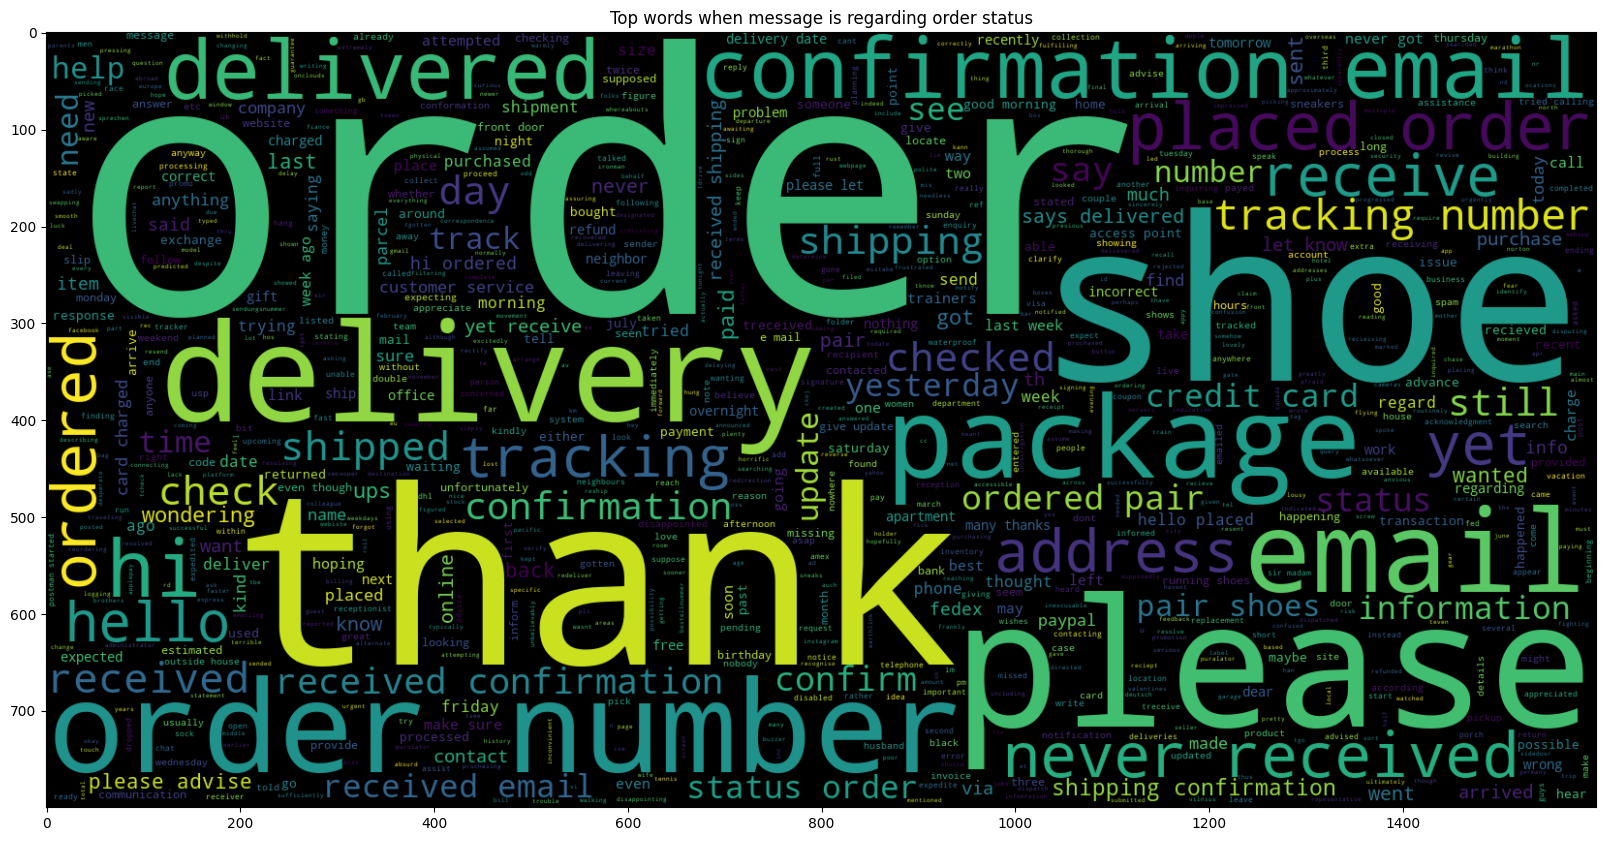

In [33]:
# Top words for label =1

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(cust_msg_df[cust_msg_df.label == 1].\
                                                                                 Description))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Top words when message is regarding order status')
plt.show()

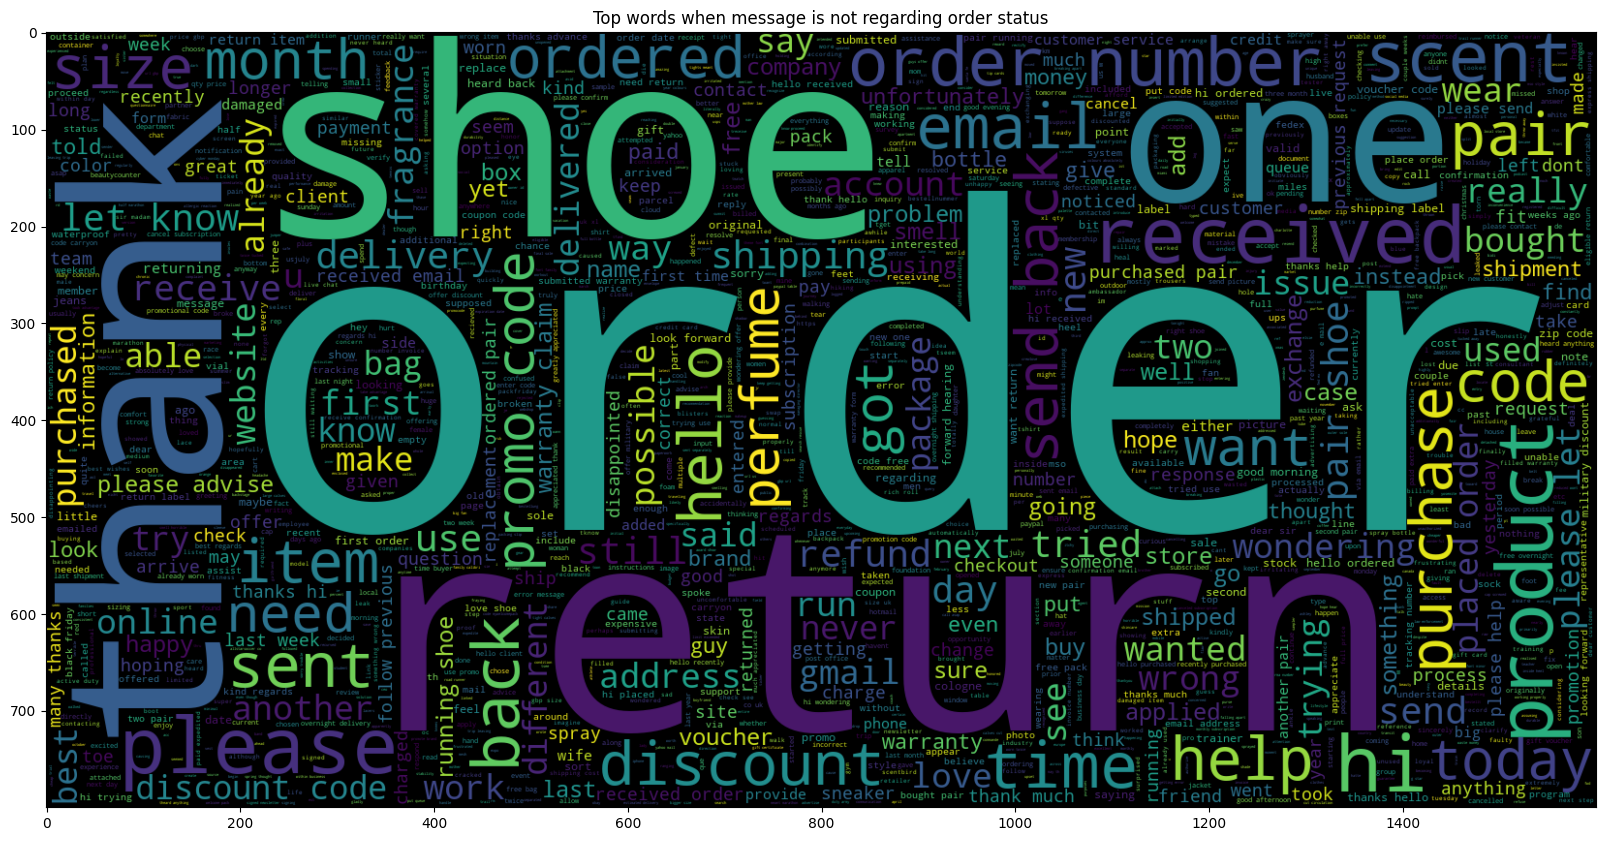

In [34]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(cust_msg_df[cust_msg_df.label == 0].\
                                                                                 Description))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Top words when message is not regarding order status')
plt.show()

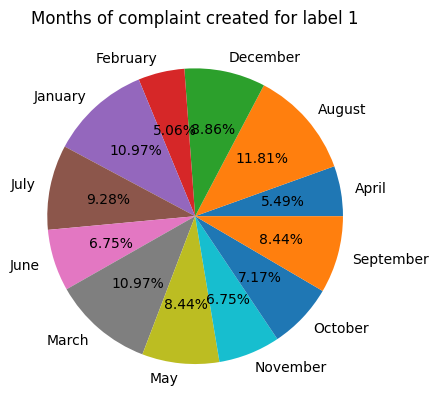

In [35]:
# Visualizing months of creation
month = cust_msg_df[cust_msg_df.label==1].Month_created.value_counts().sort_index()

plt.pie(month,labels= list(month.index),autopct='%.2f%%')
plt.title('Months of complaint created for label 1')
plt.show()

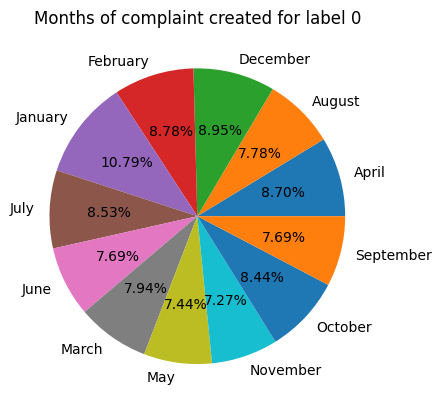

In [36]:
# Visualizing months of creation
month = cust_msg_df[cust_msg_df.label==0].Month_created.value_counts().sort_index()

plt.pie(month,labels= list(month.index),autopct='%.2f%%')
plt.title('Months of complaint created for label 0')
plt.show()

## Vectorization

In [37]:
docs = cust_msg_df.clean_tags+' '+cust_msg_df.Description
docs

0       category missing items field hi ordered pair p...
1       missing items open ticket missing pair shoes o...
2                       category missing items tget order
3       category missing items open ticket field hello...
4       category missing items open ticket shipment ne...
                              ...                        
1428    category cancel subscription open ticket subsc...
1429    category cancel subscription please cancel sub...
1430    category ticket cancel subscription return sce...
1431    category cancel subscription open ticket cance...
1432    category adverse effect open ticket field read...
Length: 1433, dtype: object

In [38]:
def tfidf_convertor(text):
    '''
    This method vectorizes the text using tf-idf vectorizer and returns the result
    '''
    vectorizer = TfidfVectorizer(ngram_range=(1,2),max_df=0.7)

    X = vectorizer.fit_transform(text)
#     print(list(vectorizer.get_feature_names_out()))
    return X

In [39]:
X= tfidf_convertor(docs)

In [40]:
X.shape

(1433, 27859)

In [41]:
# Reducing dimentions of the vectorized data to get maximum varaince using PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(1433, 1258)

Reduced the dimensonality of the data from 25859 to 1258 maintaining 95% of varaince

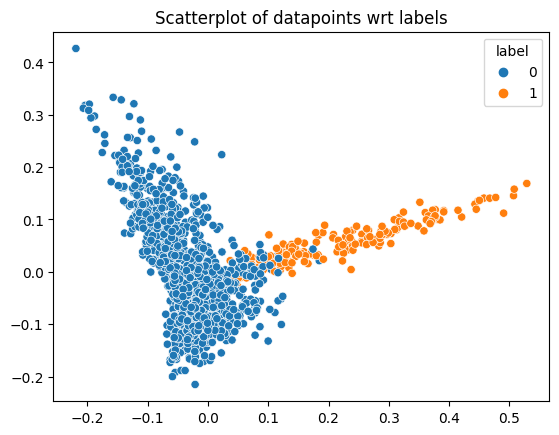

In [42]:
sns.scatterplot(x=X_reduced[:, 0],y= X_reduced[:, 1], c='m',hue= cust_msg_df.label)
plt.title('Scatterplot of datapoints wrt labels')
plt.show()

In [43]:
# Spliiting data into train and test

y= cust_msg_df.label

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.25, random_state=42)

print("Shape of train data ",X_train.shape)
print("Shape of test data ",X_test.shape)

Shape of train data  (1074, 1258)
Shape of test data  (359, 1258)


In [44]:
def tune_and_fit(param_grid,model,X=X_train, y = y_train):
    '''
    This method tunes hyper parameters for the the model passed and returns best model
    '''
    grid = GridSearchCV(model, param_grid, refit = True,cv=5)
    grid.fit(X,y)
    print("Best parameters are : ",grid.best_params_)
    return grid

In [45]:
def predict_and_evaluate(model):
    '''
    This model predicts the label for test data and prints the confusion metrics and classifcation report
    '''
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred)
    print(clr)
    
    plt.figure(figsize = (7,7))
    sns.heatmap(cm, annot = True, fmt = 'g', cbar = False, cmap = 'Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix')
    plt.show()
    return y_pred

Best parameters are :  {'C': 10, 'gamma': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       300
           1       0.98      0.83      0.90        59

    accuracy                           0.97       359
   macro avg       0.97      0.91      0.94       359
weighted avg       0.97      0.97      0.97       359



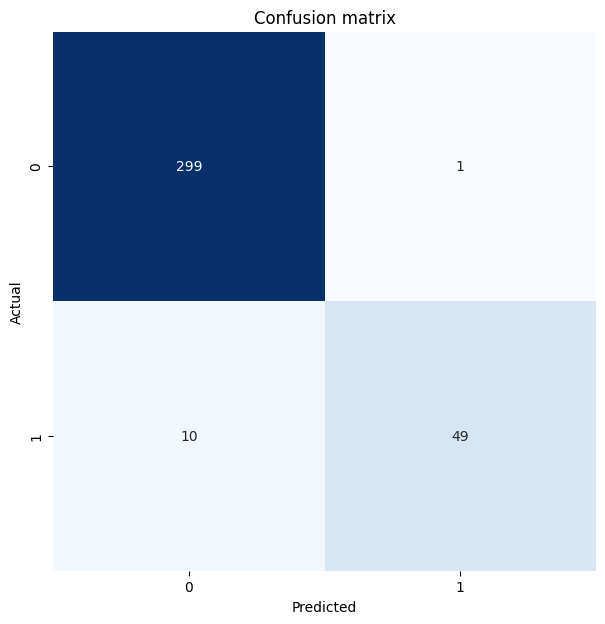

In [46]:
param_grid_svc = {'C':[1,10,20],'gamma':[1,0.1,0.01], 'kernel':['linear','rbf']}

best_model_SVC = tune_and_fit(param_grid_svc, SVC())

y_pred_svc = predict_and_evaluate(best_model_SVC)

Label 1 which indicated the messages related to order status has an F1 score of 0.9 which is sufficient.
The recall of label 1 is 0.83 which is because out of 59 points with 1 label, 49 was predicted correctly by the model.

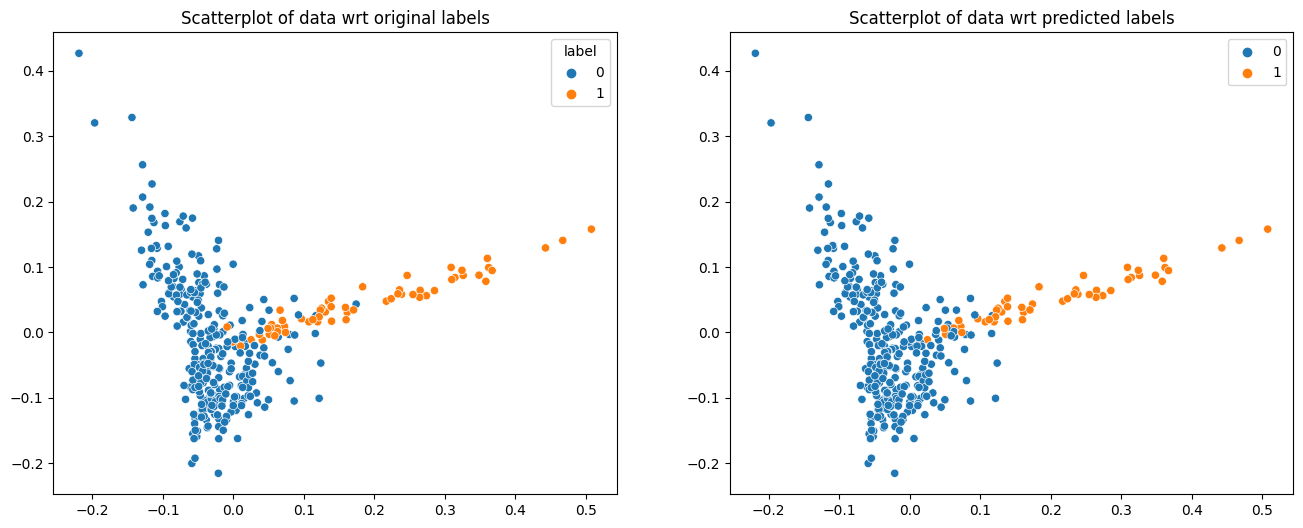

In [47]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
sns.scatterplot(x=X_test[:, 0],y= X_test[:, 1], c='m',hue= y_test,ax=ax1)
ax1.set_title('Scatterplot of data wrt original labels')



sns.scatterplot(x=X_test[:, 0],y= X_test[:, 1], c='m',hue= y_pred_svc,ax=ax2)
ax2.set_title('Scatterplot of data wrt predicted labels')
plt.show()

In [48]:
# Oversampling the data to create a balanced dataset to study the performance of the model

ROS = RandomOverSampler(sampling_strategy=1)
X_train_ros, y_train_ros = ROS.fit_resample(X_train, y_train)
print('Shape of oversampled train data in each label ',Counter(y_train_ros) )

Shape of oversampled train data in each label  Counter({1: 896, 0: 896})


In [49]:
best_model_SVC_ros = tune_and_fit(param_grid_svc, SVC(), X_train_ros, y_train_ros)

Best parameters are :  {'C': 1, 'gamma': 1, 'kernel': 'linear'}


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       300
           1       0.98      0.83      0.90        59

    accuracy                           0.97       359
   macro avg       0.97      0.91      0.94       359
weighted avg       0.97      0.97      0.97       359



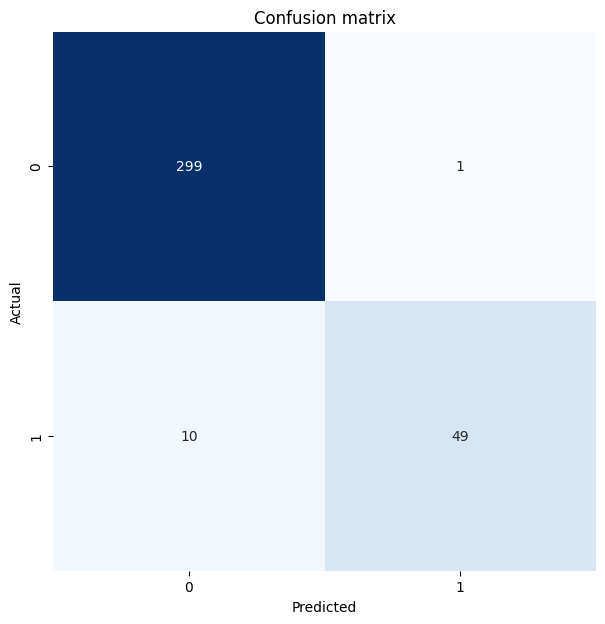

In [50]:
y_pred_svc_ros = predict_and_evaluate(best_model_SVC_ros)

over sampling did not increase the performance of the model

In [51]:
# saving best model

pickle.dump(best_model_SVC, open('svc_model.pkl', 'wb'))